In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from auxiliar_func import *
from plot_func import *

In [11]:
target = 'income_50k'
df_tr = pd.read_csv('../train.csv')

prep_par, model_par = get_best_params('./results/results_catboost.csv')
pprint(prep_par)
pprint({k: model_par[k] for k in model_par if k != 'cat_features'})

{'cat_age': False,
 'downsampling_method': 'random',
 'generate_dummies': False,
 'imputation': 'mode',
 'merge_capital': False,
 'remove_duplicates': True,
 'remove_outliers': False,
 'scaling': None,
 'target_freq': 0.85}
{'border_count': 64,
 'depth': 6,
 'eval_metric': 'F1',
 'iterations': 750,
 'loss_function': 'Logloss',
 'random_seed': 42,
 'verbose': 0}


## Metrics of the final catboost model

In [12]:
df_tr_pre = preprocessing(df_tr, **prep_par)
X_train, y_train = df_tr_pre.drop(target, axis=1), df_tr_pre[target]

cat_model = CatBoostClassifier(**model_par)
cat_model.fit(X_train, y_train)

              precision    recall  f1-score   support

           0     0.9750    0.9769    0.9760     56275
           1     0.6260    0.6069    0.6163      3582

    accuracy                         0.9548     59857
   macro avg     0.8005    0.7919    0.7961     59857
weighted avg     0.9541    0.9548    0.9544     59857



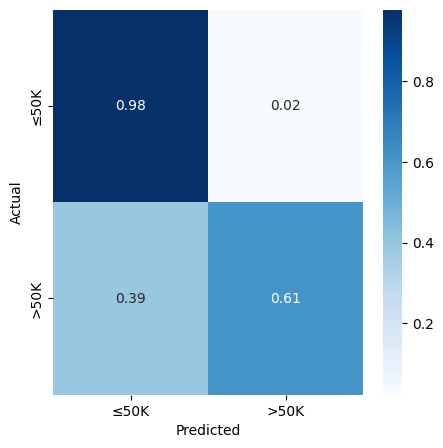

In [13]:
df_te = pd.read_csv('../test.csv')

prep_par_te = prep_par.copy()
prep_par_te['downsampling_method'] = None
prep_par_te['remove_duplicates'] = False

df_te_pre = preprocessing(df_te, **prep_par_te)

assert df_te.shape[0] == df_te_pre.shape[0]

X_test, y_test = df_te_pre.drop(target, axis=1), df_te_pre[target]

y_pred = cat_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))
plot_conf_matrix(y_test, y_pred, 'figures/test_catboost_conf_matrix.pdf')

## Feature importance of the final model

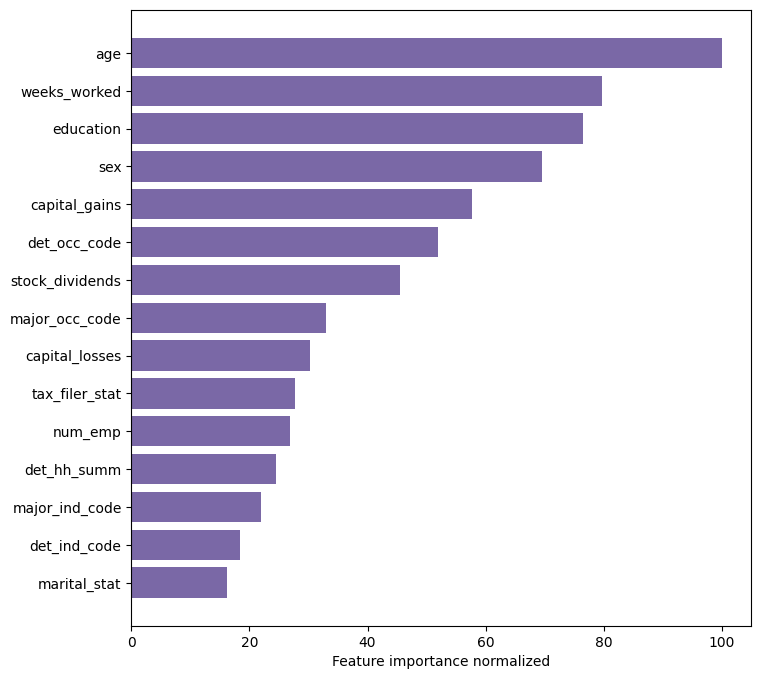

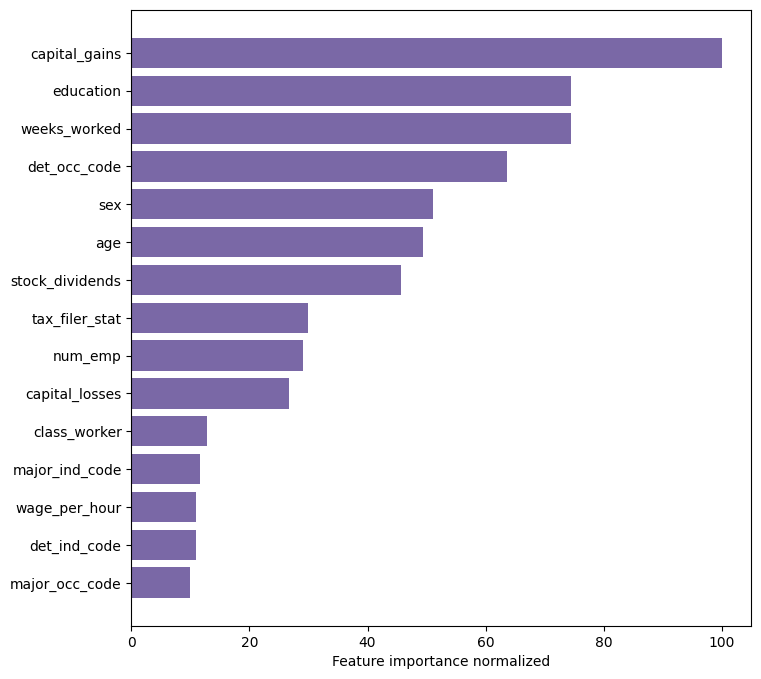

In [14]:
def plot_feature_importance_gini(model, X, n_features=20, save=''):
    feature_importance = model.get_feature_importance()
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_names = X.columns
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(8, 8))
    plt.barh(range(n_features), feature_importance[sorted_idx[-n_features:]], align='center', color='#7A68A6')
    plt.yticks(np.arange(n_features), [feature_names[i] for i in sorted_idx[-n_features:]])
    plt.xlabel('Feature importance normalized')
    if save:
        plt.savefig(save, bbox_inches='tight')
    plt.show()

def plot_feature_importance_perm(model, X, y, n_features=20, save=''):
    from sklearn.inspection import permutation_importance
    feature_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    feature_importance.importances_mean = 100.0 * (feature_importance.importances_mean / feature_importance.importances_mean.max())
    sorted_idx = np.argsort(feature_importance.importances_mean)

    # use the same format as plot_feature_importance_gini
    plt.figure(figsize=(8, 8))
    plt.barh(range(n_features), feature_importance.importances_mean[sorted_idx[-n_features:]], align='center', color='#7A68A6')
    plt.yticks(np.arange(n_features), [X.columns[i] for i in sorted_idx[-n_features:]])
    plt.xlabel('Feature importance normalized')
    if save:
        plt.savefig(save, bbox_inches='tight')
    plt.show()


# plot the feature importance
plot_feature_importance_gini(cat_model, X_train, 15, 'figures/feat_imp/feat_imp_catboost_ginb.pdf')
plot_feature_importance_perm(cat_model, X_train, y_train, 15, 'figures/feat_imp/feat_imp_catboost_perm.pdf')

In [15]:
# pool = Pool(X_train, y_train, cat_features=cat_features)

# cat_model.plot_tree(
#     tree_idx=0,
#     pool=pool
# )